In [1]:
import functools
import normflows as nf
import torch
import functools
from torch.optim import Adam
import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""  
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed 
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class LinearCond(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim, embed_dim):
    super().__init__()
    self.x_lin = nn.Linear(input_dim, output_dim)
    self.embed_lim= nn.Linear(embed_dim, output_dim)
  def forward(self, x,embed):
    return self.x_lin(x) + self.embed_lim(embed)



class ScoreNet(nn.Module):
  """A score network that estimates the score of a trajectory."""
  def __init__(self, input_dim, embed_dim):

    super().__init__()
    self.embed = nn.Sequential(
      GaussianFourierProjection(embed_dim),
      nn.Linear(embed_dim, embed_dim),
    )

    self.linear1 = LinearCond(input_dim,128,embed_dim)
    self.linear2 = LinearCond(128,128,embed_dim)
    self.linear3 = LinearCond(128,128,embed_dim)
    self.output = nn.Linear(128,input_dim)

  def forward(self, x, t):
    emb = F.softplus(self.embed(t))

    x = self.linear1(x,emb)
    x = F.softplus(x)
    x = self.linear2(x,emb)
    x = F.softplus(x)
    x = self.linear3(x,emb)
    x = F.softplus(x)
    x = self.output(x)
    return x

In [3]:
from tools.sde_lib import VESDE

In [4]:
test_sde=VESDE(sigma_min=0.01,sigma_max=1,N=100)

In [5]:
test_sde.discrete_sigmas

tensor([0.0100, 0.0105, 0.0110, 0.0115, 0.0120, 0.0126, 0.0132, 0.0138, 0.0145,
        0.0152, 0.0159, 0.0167, 0.0175, 0.0183, 0.0192, 0.0201, 0.0210, 0.0221,
        0.0231, 0.0242, 0.0254, 0.0266, 0.0278, 0.0292, 0.0305, 0.0320, 0.0335,
        0.0351, 0.0368, 0.0385, 0.0404, 0.0423, 0.0443, 0.0464, 0.0486, 0.0509,
        0.0534, 0.0559, 0.0586, 0.0614, 0.0643, 0.0673, 0.0705, 0.0739, 0.0774,
        0.0811, 0.0850, 0.0890, 0.0933, 0.0977, 0.1024, 0.1072, 0.1123, 0.1177,
        0.1233, 0.1292, 0.1353, 0.1417, 0.1485, 0.1556, 0.1630, 0.1707, 0.1789,
        0.1874, 0.1963, 0.2057, 0.2154, 0.2257, 0.2364, 0.2477, 0.2595, 0.2719,
        0.2848, 0.2984, 0.3126, 0.3275, 0.3430, 0.3594, 0.3765, 0.3944, 0.4132,
        0.4329, 0.4535, 0.4751, 0.4977, 0.5214, 0.5462, 0.5722, 0.5995, 0.6280,
        0.6579, 0.6893, 0.7221, 0.7565, 0.7925, 0.8302, 0.8697, 0.9112, 0.9545,
        1.0000])

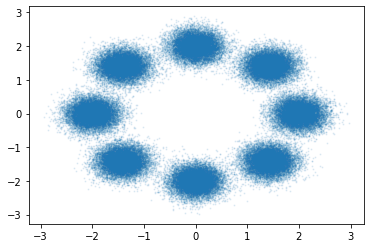

In [6]:
target = nf.distributions.CircularGaussianMixture()
data = target.sample(100000)

plt.scatter(data.numpy()[:,0], data.numpy()[:,1], s=1, alpha=0.1)

# from sklearn.datasets import make_swiss_roll
# def sample_batch(size, noise=0.5):
#     x, _= make_swiss_roll(size, noise=noise)
#     return x[:, [0, 2]] / 10.0
# data = sample_batch(10**4)
# data = torch.tensor(data).float()

# plt.scatter(data[:,0], data[:,1], s=1, alpha=0.1)

KeyboardInterrupt: 

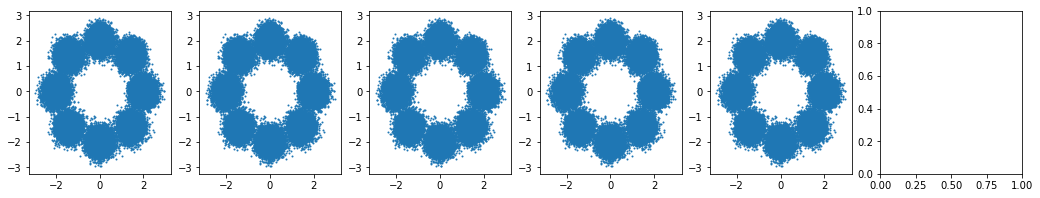

In [7]:
stds = test_sde.discrete_sigmas
plt.figure(figsize=(30,3))
z = torch.randn_like(data)
for i,std in enumerate(stds):
    perturbed_x = data + z * std
    plt.subplot(1,10,i+1)
    plt.scatter(*perturbed_x.T,s=1)

In [8]:
from tools.loss import sde_score_matching_loss
device='cuda'

In [9]:
score_model = ScoreNet(input_dim=2, embed_dim=4)
score_model = score_model.to(device)

n_epochs =   50
## size of a mini-batch
batch_size =  256

lr=1e-3

optimizer = Adam(score_model.parameters(), lr=lr)
tqdm_epoch = tqdm.notebook.trange(n_epochs)

dataset = torch.tensor(data, dtype=torch.float32).to(device)

for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  permutation = torch.randperm(dataset.size()[0])
  
  for i in range(0, dataset.size()[0], batch_size):
    indices = permutation[i:i+batch_size]
    batch_x = dataset[indices] 

    loss = sde_score_matching_loss(score_model, batch_x, test_sde)
    optimizer.zero_grad()
    loss.backward()    
    optimizer.step()
    avg_loss += loss.item() * batch_x.shape[0]
    num_items += batch_x.shape[0]
  # Print the averaged training loss so far.
  tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  # Update the checkpoint after each epoch of training.
  # torch.save(score_model.state_dict(), 'ckpt.pth')

  0%|          | 0/50 [00:00<?, ?it/s]

/tmp/ipykernel_3850868/3302002421.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = torch.tensor(data, dtype=torch.float32).to(device)


(-3.0, 3.0)

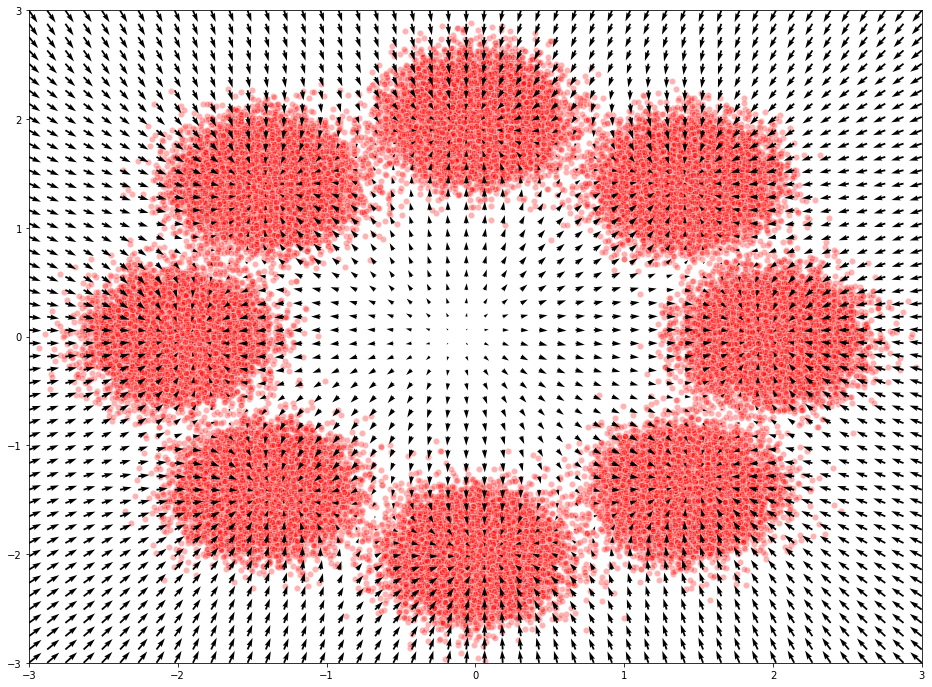

In [10]:
xx = np.stack(np.meshgrid(np.linspace(-3, 3.0, 50), np.linspace(-3, 3.0, 50)), axis=-1).reshape(-1, 2)
# xx = np.stack(np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50)), axis=-1).reshape(-1, 2)
times = torch.ones(xx.shape[0]).to(device)*1e-5
scores = score_model(torch.tensor(xx).float().to(device), times).detach().cpu().numpy()
scores_norm = np.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
scores_log1p = scores / (scores_norm + 1e-9) * np.log1p(scores_norm)
# Perform the plots
plt.figure(figsize=(16,12))
plt.scatter(*data.T, alpha=0.3, color='red', edgecolor='white', s=40)
plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='black')
plt.xlim(-3, 3)
plt.ylim(-3, 3)

# plt.xlim(-5, 5)
# plt.ylim(-5, 5)

In [11]:
from tools.sde_sampler import PC_sampler

In [12]:
pc_sampler=PC_sampler(test_sde,score_model,n_correct_steps=1000,snr=1e-3)

In [13]:
test_samles=pc_sampler.sample(10000)

In [14]:
test_samles.shape

torch.Size([10000, 2])

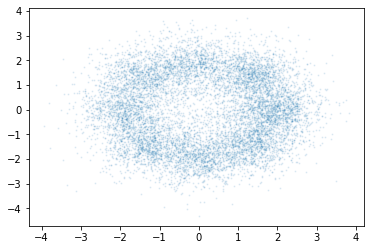

In [15]:
plt.scatter(*test_samles.cpu().T, s=1, alpha=0.1)

In [16]:
from tools.sde_sampler import ode_sampler

In [17]:
o_sampler=ode_sampler(test_sde,score_model)

In [18]:
test_samples=o_sampler.sample(10000)[0]

AttributeError: 'ode_sampler' object has no attribute 'sample'

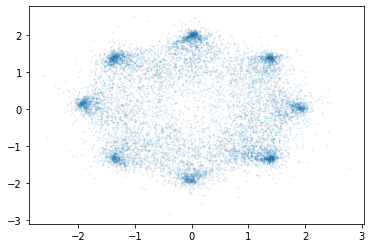

In [29]:
plt.scatter(*test_samples.cpu().T, s=1, alpha=0.1)

In [35]:
o_likelihood= ode_likelihood(test_sde,score_model)

In [34]:
test_sde=VESDE(sigma_min=0.01,sigma_max=1,N=100)

In [36]:
xx = np.stack(np.meshgrid(np.linspace(-3, 3.0, 50), np.linspace(-3, 3.0, 50)), axis=-1).reshape(-1, 2)

xx = torch.tensor(xx).float().to(device)
bpd = o_likelihood.likelihood_eval(xx)

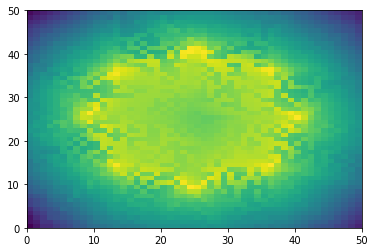

In [37]:
plt.pcolor(-(bpd.cpu().numpy().reshape(50,50)))

In [108]:
device = 'cuda' 
const =5e-2

def marginal_prob_std(t, sigma):
  """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:    
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.  
  
  Returns:
    The standard deviation.
  """    
  t = torch.tensor(t, device=device)
  return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))*const

def diffusion_coeff(t, sigma):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.
  
  Returns:
    The vector of diffusion coefficients.
  """
  return torch.tensor(sigma**t, device=device)*const
  
sigma =100#@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

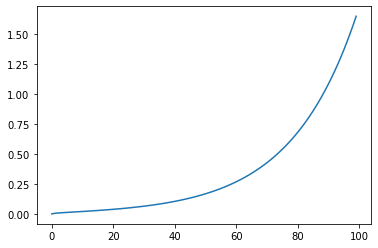

In [109]:
plt.plot(marginal_prob_std_fn(np.linspace(0, 1, 100)).cpu().numpy())

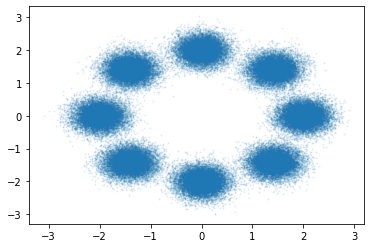

In [110]:
target = nf.distributions.CircularGaussianMixture()
data = target.sample(100000)

plt.scatter(data.numpy()[:,0], data.numpy()[:,1], s=1, alpha=0.1)

# from sklearn.datasets import make_swiss_roll
# def sample_batch(size, noise=0.5):
#     x, _= make_swiss_roll(size, noise=noise)
#     return x[:, [0, 2]] / 10.0
# data = sample_batch(10**4)
# data = torch.tensor(data).float()

# plt.scatter(data[:,0], data[:,1], s=1, alpha=0.1)

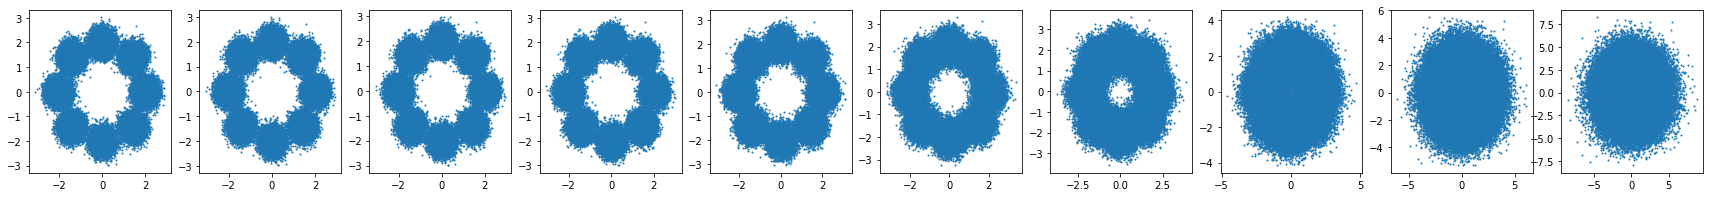

In [112]:
stds = marginal_prob_std_fn(np.linspace(1e-5, 1, 10)).cpu().numpy()
plt.figure(figsize=(30,3))
z = torch.randn_like(data)
for i,std in enumerate(stds):
    perturbed_x = data + z * std
    plt.subplot(1,10,i+1)
    plt.scatter(*perturbed_x.T,s=1)

In [113]:
#@title Define the loss function (double click to expand or collapse)

def loss_fn(model, x, marginal_prob_std, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a 
      time-dependent score-based model.
    x: A mini-batch of training data.    
    marginal_prob_std: A function that gives the standard deviation of 
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps  
  z = torch.randn_like(x)
  std = marginal_prob_std(random_t)
  perturbed_x = x + z * std[:, None]
  score = model(perturbed_x, random_t)
  loss = torch.mean(torch.sum((score* std[:, None] + z)**2, dim=(1)))
  return loss

In [114]:
score_model = ScoreNet(input_dim=2, embed_dim=4)
score_model = score_model.to(device)

n_epochs =   50
## size of a mini-batch
batch_size =  256

lr=1e-3

optimizer = Adam(score_model.parameters(), lr=lr)
tqdm_epoch = tqdm.notebook.trange(n_epochs)

dataset = torch.tensor(data, dtype=torch.float32).to(device)

for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  permutation = torch.randperm(dataset.size()[0])
  
  for i in range(0, dataset.size()[0], batch_size):
    indices = permutation[i:i+batch_size]
    batch_x = dataset[indices] 

    loss = loss_fn(score_model, batch_x, marginal_prob_std_fn)
    optimizer.zero_grad()
    loss.backward()    
    optimizer.step()
    avg_loss += loss.item() * batch_x.shape[0]
    num_items += batch_x.shape[0]
  # Print the averaged training loss so far.
  tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  # Update the checkpoint after each epoch of training.
  # torch.save(score_model.state_dict(), 'ckpt.pth')

  0%|          | 0/50 [00:00<?, ?it/s]

/tmp/ipykernel_3653493/2084854805.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = torch.tensor(data, dtype=torch.float32).to(device)
/tmp/ipykernel_3653493/1000712202.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


(-3.0, 3.0)

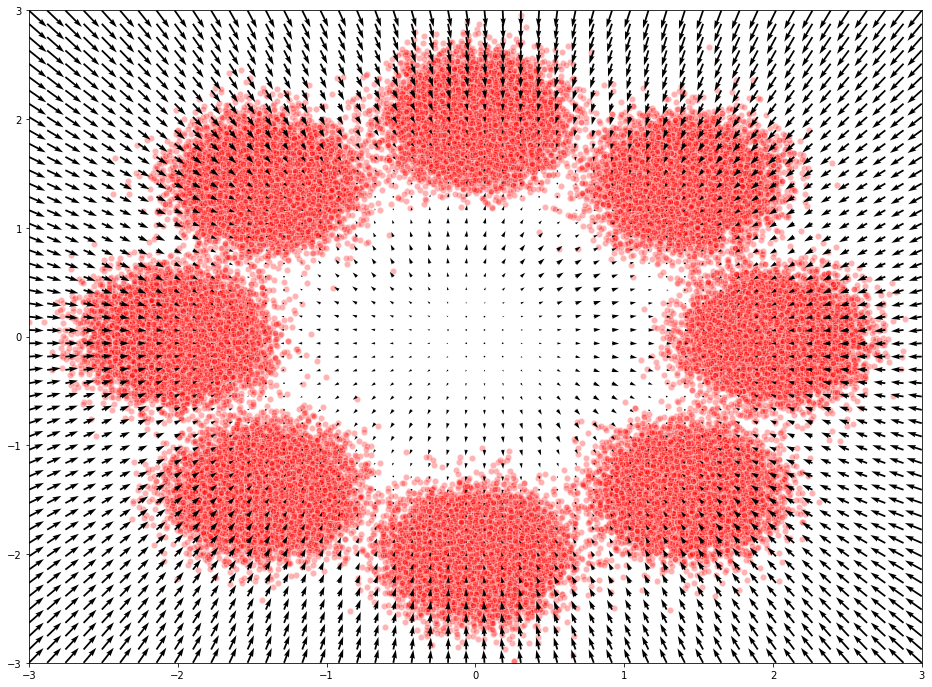

In [115]:
xx = np.stack(np.meshgrid(np.linspace(-3, 3.0, 50), np.linspace(-3, 3.0, 50)), axis=-1).reshape(-1, 2)
# xx = np.stack(np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50)), axis=-1).reshape(-1, 2)
times = torch.ones(xx.shape[0]).to(device)*1e-5
scores = score_model(torch.tensor(xx).float().to(device), times).detach().cpu().numpy()
scores_norm = np.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
scores_log1p = scores / (scores_norm + 1e-9) * np.log1p(scores_norm)
# Perform the plots
plt.figure(figsize=(16,12))
plt.scatter(*data.T, alpha=0.3, color='red', edgecolor='white', s=40)
plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color='black')
plt.xlim(-3, 3)
plt.ylim(-3, 3)

# plt.xlim(-5, 5)
# plt.ylim(-5, 5)

In [117]:
#@title Define the Euler-Maruyama sampler (double click to expand or collapse)

## The number of sampling steps.
num_steps =  500#@param {'type':'integer'}
def Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std,
                           diffusion_coeff, 
                           batch_size=64, 
                           num_steps=num_steps, 
                           device='cuda', 
                           eps=1e-3):
  """Generate samples from score-based models with the Euler-Maruyama solver.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps. 
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.
  
  Returns:
    Samples.    
  """
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, 2, device=device) \
    * marginal_prob_std(t)[:, None]
  time_steps = torch.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm.notebook.tqdm(time_steps):      
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      g = diffusion_coeff(batch_time_step)
      mean_x = x + (g**2)[:, None] * score_model(x, batch_time_step) * step_size
      x = mean_x + torch.sqrt(step_size) * g[:, None] * torch.randn_like(x)      
  # Do not include any noise in the last sampling step.
  return mean_x

In [118]:
#@title Define the Predictor-Corrector sampler (double click to expand or collapse)

signal_to_noise_ratio = 1e-1 #@param {'type':'number'}

## The number of sampling steps.
num_steps =  500#@param {'type':'integer'}
def pc_sampler(score_model, 
               marginal_prob_std,
               diffusion_coeff,
               batch_size=64, 
               num_steps=num_steps, 
               num_Langevin_steps=1000,
               snr=signal_to_noise_ratio,                
               device='cuda',
               eps=1e-3):
  """Generate samples from score-based models with Predictor-Corrector method.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation
      of the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient 
      of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps. 
      Equivalent to the number of discretized time steps.    
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.
  
  Returns: 
    Samples.
  """
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size,2, device=device) * marginal_prob_std(t)[:, None]
  time_steps = np.linspace(1., eps, num_steps)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm.notebook.tqdm(time_steps):      
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      # Corrector step (Langevin MCMC)
      for _ in range(num_Langevin_steps):
        grad = score_model(x, batch_time_step)
        grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
        noise_norm = np.sqrt(np.prod(x.shape[1:]))
        langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
        x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)      

      # Predictor step (Euler-Maruyama)
      g = diffusion_coeff(batch_time_step)
      x_mean = x + (g**2)[:, None] * score_model(x, batch_time_step) * step_size
      x = x_mean + torch.sqrt(g**2 * step_size)[:, None] * torch.randn_like(x)      
    
    # The last step does not include any noise
    return x_mean

In [119]:
test_samples=pc_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, batch_size=10000, num_steps=100, snr=1e-2, device=device,eps=1e-5)

/tmp/ipykernel_3653493/1000712202.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_3653493/1000712202.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)*const


In [120]:
test_samples.shape

torch.Size([10000, 2])

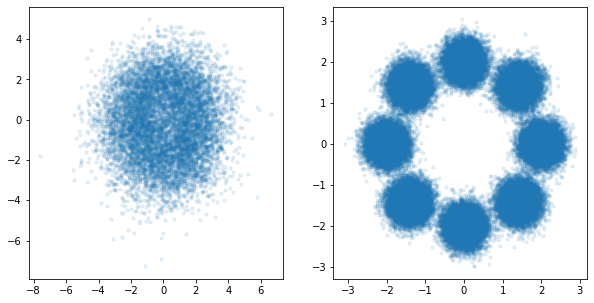

In [121]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(*test_samples.cpu().T , s=10,alpha=0.1)
plt.subplot(122)
plt.scatter(*data.T , s=10,alpha=0.1)

In [99]:
#@title Define the ODE sampler (double click to expand or collapse)

from scipy import integrate

## The error tolerance for the black-box ODE solver
error_tolerance = 1e-6 #@param {'type': 'number'}
def ode_sampler(score_model,
                marginal_prob_std,
                diffusion_coeff,
                batch_size=64, 
                atol=error_tolerance, 
                rtol=error_tolerance, 
                device='cuda', 
                z=None,
                eps=1e-3):
  """Generate samples from score-based models with black-box ODE solvers.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that returns the standard deviation 
      of the perturbation kernel.
    diffusion_coeff: A function that returns the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    atol: Tolerance of absolute errors.
    rtol: Tolerance of relative errors.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    z: The latent code that governs the final sample. If None, we start from p_1;
      otherwise, we start from the given z.
    eps: The smallest time step for numerical stability.
  """
  t = torch.ones(batch_size, device=device)
  # Create the latent code
  if z is None:
    init_x = torch.randn(batch_size, 2, device=device) \
      * marginal_prob_std(t)[:, None]
  else:
    init_x = z


  ## Corrector step (Langevin MCMC)
  batch_time_step = torch.ones(batch_size, device=device)
  for _ in range(1000):
    with torch.no_grad():
      grad = score_model(init_x, batch_time_step)
    grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
    noise_norm = np.sqrt(np.prod(init_x.shape[1:]))
    langevin_step_size = 2 * (1e-1 * noise_norm / grad_norm)**2
    init_x = init_x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(init_x)   
    
  shape = init_x.shape

  def score_eval_wrapper(sample, time_steps):
    """A wrapper of the score-based model for use by the ODE solver."""
    sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
    time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))    
    with torch.no_grad():    
      score = score_model(sample, time_steps)
    return score.cpu().numpy().reshape((-1,)).astype(np.float64)
  
  def ode_func(t, x):        
    """The ODE function for use by the ODE solver."""
    time_steps = np.ones((shape[0],)) * t    
    g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
    return  -0.5 * (g**2) * score_eval_wrapper(x, time_steps)
  
  # Run the black-box ODE solver.
  res = integrate.solve_ivp(ode_func, (1., eps), init_x.reshape(-1).cpu().numpy(), rtol=rtol, atol=atol, method='RK45')  
  print(f"Number of function evaluations: {res.nfev}")
  x = torch.tensor(res.y[:, -1], device=device).reshape(shape)

  return x,init_x

In [101]:

sample_batch_size = 10000 #@param {'type':'integer'}
sampler = ode_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}

## Generate samples using the specified sampler.
samples,init_samples = sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size, 
                  device=device,
                  eps=1e-5)

# ## Sample visualization.
# samples = samples.clamp(0.0, 1.0)

/tmp/ipykernel_3653493/452628102.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


Number of function evaluations: 146


/tmp/ipykernel_3653493/452628102.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)*const


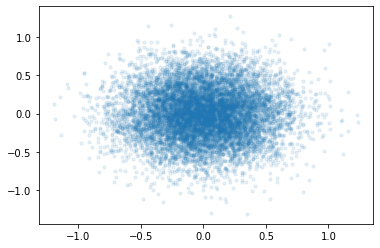

In [98]:

plt.scatter(*init_x.cpu().T , s=10,alpha=0.1)

In [81]:
samples.shape

torch.Size([10000, 2])

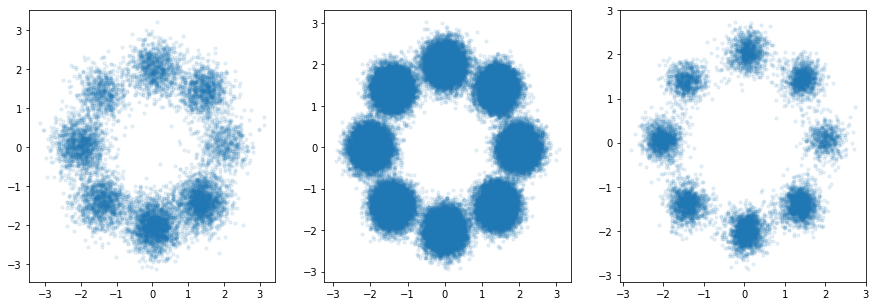

In [102]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.scatter(*test_samples.cpu().T , s=10,alpha=0.1)
plt.subplot(132)
plt.scatter(*data.T , s=10,alpha=0.1)
plt.subplot(133)
plt.scatter(*samples.cpu().T , s=10,alpha=0.1)

# plt.scatter(*samples.cpu().T,s=1)

In [103]:
#@title Define the likelihood function (double click to expand or collapse)

def prior_likelihood(z, sigma):
  """The likelihood of a Gaussian distribution with mean zero and 
      standard deviation sigma."""
  shape = z.shape
  N = np.prod(shape[1:])
  return -N / 2. * torch.log(2*np.pi*sigma**2) - torch.sum(z**2, dim=(-1)) / (2 * sigma**2)

def ode_likelihood(x, 
                   score_model,
                   marginal_prob_std, 
                   diffusion_coeff,
                   batch_size=64, 
                   device='cuda',
                   eps=1e-5):
  """Compute the likelihood with probability flow ODE.
  
  Args:
    x: Input data.
    score_model: A PyTorch model representing the score-based model.
    marginal_prob_std: A function that gives the standard deviation of the 
      perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the 
      forward SDE.
    batch_size: The batch size. Equals to the leading dimension of `x`.
    device: 'cuda' for evaluation on GPUs, and 'cpu' for evaluation on CPUs.
    eps: A `float` number. The smallest time step for numerical stability.

  Returns:
    z: The latent code for `x`.
    bpd: The log-likelihoods in bits/dim.
  """

  # Draw the random Gaussian sample for Skilling-Hutchinson's estimator.
  epsilon = torch.randn_like(x)
      
  def divergence_eval(sample, time_steps, epsilon):      
    """Compute the divergence of the score-based model with Skilling-Hutchinson."""
    with torch.enable_grad():
      sample.requires_grad_(True)
      score_e = torch.sum(score_model(sample, time_steps) * epsilon)
      grad_score_e = torch.autograd.grad(score_e, sample)[0]
    return torch.sum(grad_score_e * epsilon, dim=(-1))    
  
  shape = x.shape

  def score_eval_wrapper(sample, time_steps):
    """A wrapper for evaluating the score-based model for the black-box ODE solver."""
    sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
    time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))    
    with torch.no_grad():    
      score = score_model(sample, time_steps)
    return score.cpu().numpy().reshape((-1,)).astype(np.float64)
  
  def divergence_eval_wrapper(sample, time_steps):
    """A wrapper for evaluating the divergence of score for the black-box ODE solver."""
    with torch.no_grad():
      # Obtain x(t) by solving the probability flow ODE.
      sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
      time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))    
      # Compute likelihood.
      div = divergence_eval(sample, time_steps, epsilon)
      return div.cpu().numpy().reshape((-1,)).astype(np.float64)
  
  def ode_func(t, x):
    """The ODE function for the black-box solver."""
    time_steps = np.ones((shape[0],)) * t    
    sample = x[:-shape[0]]
    logp = x[-shape[0]:]
    g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
    sample_grad = -0.5 * g**2 * score_eval_wrapper(sample, time_steps)
    logp_grad = -0.5 * g**2 * divergence_eval_wrapper(sample, time_steps)
    return np.concatenate([sample_grad, logp_grad], axis=0)

  init = np.concatenate([x.cpu().numpy().reshape((-1,)), np.zeros((shape[0],))], axis=0)
  # Black-box ODE solver
  res = integrate.solve_ivp(ode_func, (eps, 1.), init, rtol=1e-5, atol=1e-5, method='RK45')  
  zp = torch.tensor(res.y[:, -1], device=device)
  z = zp[:-shape[0]].reshape(shape)
  delta_logp = zp[-shape[0]:].reshape(shape[0])
  sigma_max = marginal_prob_std(1.)
  prior_logp = prior_likelihood(z, sigma_max)
  bpd = -(prior_logp + delta_logp) / np.log(2)
  N = np.prod(shape[1:])
  bpd = bpd / N + 8.
  return z, bpd

In [22]:
batch_size=100
idx = torch.randperm(dataset.size()[0])[:batch_size]
x=dataset[idx]

_, bpd = ode_likelihood(x, score_model, marginal_prob_std_fn,
                        diffusion_coeff_fn,
                        x.shape[0], device=device, eps=1e-5)

/tmp/ipykernel_3653493/4129739035.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)*1e-3


In [65]:
bpd

tensor([25.6717, 32.6587, 37.7284, 16.9203, 25.2524, 22.0641, 34.8094, 50.2364,
        37.5086, 13.5014, 20.3304, 22.7835, 21.3527, 24.2381, 19.3180, 30.9115,
        33.6548, 30.3726, 25.1879, 26.3022, 20.9961, 33.0709, 24.6602, 29.3401,
        29.6103, 30.3566, 23.4204, 27.0341, 40.5933, 18.9656, 20.0784, 34.3735,
        25.6092, 25.2543, 18.1929, 15.3427, 17.6950, 21.5808, 29.1381, 23.8622,
        24.2482, 30.6649, 18.2547, 32.3668, 21.6333, 38.0091, 19.5542, 33.1437,
        30.1597, 20.6434, 31.9489, 25.7514, 21.4412, 37.7764, 31.6338, 29.8642,
        15.5566, 25.1403, 30.9288, 25.9246, 22.2851, 33.3728, 35.4312, 20.5137,
        32.8801, 37.0206, 32.6828, 26.4419, 37.9726, 30.5884, 29.6488, 22.2922,
        33.1804, 17.3456, 25.5257, 26.3976, 18.2389, 20.2307, 31.7613, 21.7759,
        24.4461, 25.4688, 22.1681, 22.7253, 22.3410, 24.8555, 22.9739, 37.1860,
        29.5549, 27.4844, 20.3474, 29.6652, 26.6132, 36.6868, 32.4684, 36.6594,
        28.7693, 26.8228, 28.2724, 31.56

In [104]:
xx = np.stack(np.meshgrid(np.linspace(-3, 3.0, 50), np.linspace(-3, 3.0, 50)), axis=-1).reshape(-1, 2)

xx = torch.tensor(xx).float().to(device)
_, bpd = ode_likelihood(xx, score_model, marginal_prob_std_fn,
                        diffusion_coeff_fn,
                        xx.shape[0], device=device, eps=1e-5)

/tmp/ipykernel_3653493/452628102.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)*const


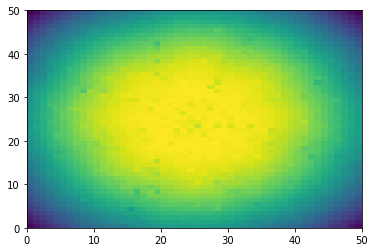

In [105]:
plt.pcolor(-(bpd.cpu().numpy().reshape(50,50)))